In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

import nltk, keras, string, html, math
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter, defaultdict
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from gensim.parsing.preprocessing import remove_stopwords 
from gensim.models import Word2Vec
from tensorflow.keras import layers
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nickb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nickb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nickb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# read data, assign column names, skip header
data = pd.read_csv("depression_dataset_reddit_cleaned.csv", names=["text", "is_depression"], header=0)

# Visualiziation of data

### not depressed = blue | depressions = orange

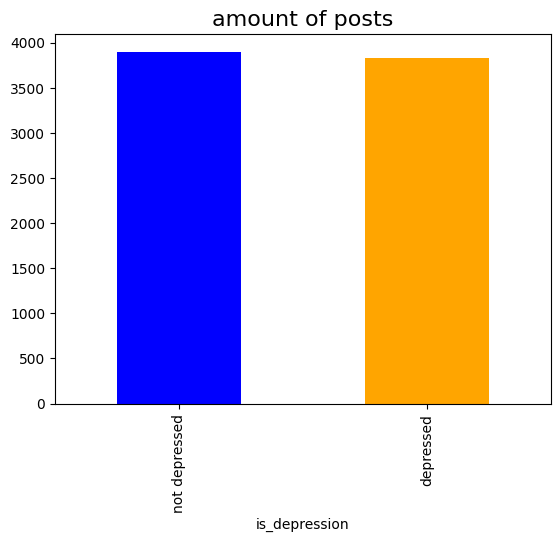

In [4]:
counts = data["is_depression"].map({0: "not depressed", 1: "depressed"}).value_counts()

counts.plot(kind='bar', color=['blue', 'orange'])
plt.title("amount of posts", fontsize=16)

plt.show()

the data is evenly distributet

### Comparing the lenght of the texts

loss not depressed 0
loss depressed 587


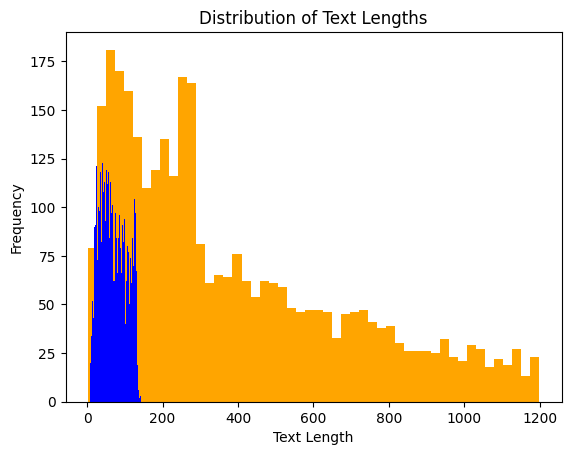

In [5]:
data["length"] = data["text"].apply(len)

notDepressed = data[data["is_depression"] == 0]
depressed = data[data["is_depression"] == 1]

nD = len(notDepressed)
d = len(depressed)

# for better visualization
notDepressed = notDepressed[notDepressed["length"] < 1200]
depressed = depressed[depressed["length"] < 1200]

# how many posts did we lose
print(f"loss not depressed {nD - len(notDepressed)}")
print(f"loss depressed {d - len(depressed)}")

plt.hist(depressed['length'], color='orange', bins=50)
plt.hist(notDepressed['length'],color='blue', bins=50)



plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Preprocessing

### Removing Stop Words => keeping important words

In [6]:
def removingStopWords(text):
    words = text.split(' ')
    valuedWords = [word for word in words if word not in stopwords.words('english')]
    return valuedWords

data["valueWords"] = data["text"].apply(removingStopWords)
data["valueLength"] = data["valueWords"].apply(len)

data

text  \
0     we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i e pm chat or any kind of offsite communication early in the conversion is showing either bad intention or bad judgement either way it s unwise to trust them pm me anytime seems like a kind and generous offer and it might be perfectly well meaning but unless and until a solid rapport ha been established it s just not a wise idea here are some point to consider before you offer or accept an invitation to communicate privately by posting supportive reply publicly you ll help more people than just the op if your response are of good quality you ll educate and inspire other helper the 9 90 rule http en wikipedia org wiki rule internet culture applies here a much a it doe anywhere else on the internet people who are struggling with serious mental health issue often justifiably have a low tolerance for disappointment and a high level of ever changing emotional need unless the helper is able to make a 00 commitment to be there for them in every way for a long a necessary offering a personal inbox a a resource is likely to do more harm than good this is why mental health crisis line responder usually don t give their name and caller aren t allowed to request specific responder it s much healthier and safer for the caller to develop a relationship with the agency a a whole analogously it s much safer and healthier for our ops to develop a relationship with the community a a whole even trained responder are generally not allowed to work high intensity situation alone it s partly about availability but it s mostly about wider perspective and preventing compassion fatigue if a helper get in over their head with someone whose mental health issue including suicidality which is often comorbid with depression escalate in a pm conversation it s much harder for others including the r depression and r suicidewatch moderator to help contrary to common assumption moderator can t see or police pm in our observation over many year the people who say pm me the most are consistently the one with the least understanding of mental health issue and mental health support we all have gap in our knowledge and in our ability to communicate effectively community input mitigates these limitation there s no reason why someone who s truly here to help would want to hide their response from community scrutiny if helper are concerned about their own privacy keep in mind that self disclosure when used supportively is more about the feeling than the detail and that we have no problem here with the use of alt throwaway account and have no restriction on account age or karma we all know the internet is used by some people to exploit or abuse others these people do want to hide their deceptive and manipulative response from everyone except their victim there are many of them who specifically target those who are vulnerable because of mental health issue if a helper invite an op to talk privately and give them a good supportive experience they ve primed that person to be more vulnerable

### Text Lengths vs. Valued Words

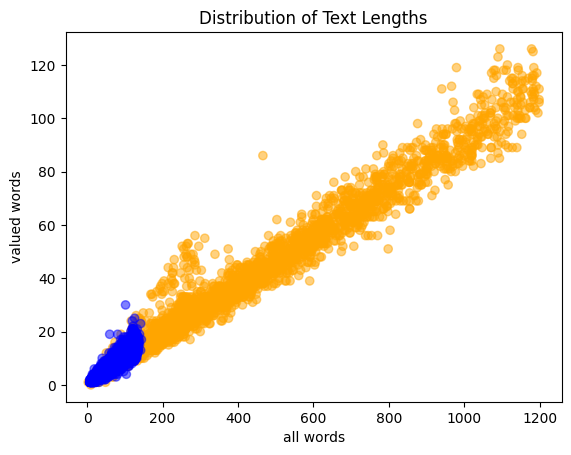

In [7]:

words = data[data["length"] < 1200]

colorMap = ["blue", "orange"]
colors = [colorMap[val] for val in words["is_depression"]]

plt.scatter(words["length"],words["valueLength"], color=colors, marker='o', alpha=0.5)


plt.title('Distribution of Text Lengths')
plt.xlabel('all words')
plt.ylabel('valued words')
plt.show()

In [8]:
data['valueText'] = data["valueWords"].apply(lambda  x: ' '.join(x))

### Creating word clouds to show most frequently occurring words

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

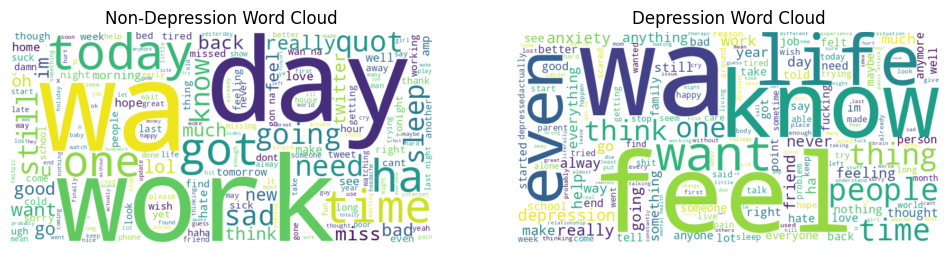

In [9]:
ndText = ' '.join(data['valueText'].loc[data['is_depression']==0])
dText = ' '.join(data['valueText'].loc[data['is_depression']==1])

# Create WordCloud objects for each category
ndWordcloud = WordCloud(width=800, height=400, background_color='white').generate(ndText)
dWordcloud = WordCloud(width=800, height=400, background_color='white').generate(dText)


plt.rcParams['font.sans-serif'] = 'Arial'


# Display the non-depression word cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ndWordcloud, interpolation='bilinear')
plt.title('Non-Depression Word Cloud')
plt.axis('off')

# Display the depression word cloud
plt.subplot(1, 2, 2)
plt.imshow(dWordcloud, interpolation='bilinear')
plt.title('Depression Word Cloud')
plt.axis('off')

plt.show()

In [10]:
# look at some samples
print("depression:\n" + 
      str(data[data["is_depression"] == 1].sample(n=3).text.tolist()))
print("not depression:\n" + 
      str(data[data["is_depression"] == 0].sample(n=3).text.tolist()))

depression:
['don t let depression slow you down we got this', 'it s been five year and a couple day now since my first major attempt i m not too sure how i feel to be honest ha life improved well not really of course after that first attempt i tried a couple more time i think if we look at the net value i m relatively in the same spot a i wa five year ago vibing on the bridge thankfully i m not too upset about that i think sadness and my inability to get out of said sadness is something that i will have to live with i m getting better at fighting it that s for sure are some day tiring and fucking unbearable of course but now i m just content with existing sad day are hard some day are easy i think i m just shocked that i m still alive well i definitely know that younger me would be shocked i m still kicking around maybe he d be happy that i stayed for this long there really isn t any point to this post just a bit of selfish self congratulation and the ability to say i m still alive gu

In [11]:
# class balance
print(data[data["is_depression"] == 1].count())
print(data[data["is_depression"] == 0].count())

text             3831
is_depression    3831
length           3831
valueWords       3831
valueLength      3831
valueText        3831
dtype: int64
text             3900
is_depression    3900
length           3900
valueWords       3900
valueLength      3900
valueText        3900
dtype: int64


### Looking at the length of the texts

In [12]:
# the samples suggest, the is_depression texts are longer than the others. Is that really so?
# print average length, min length and max length of elements shows that length could be an important factor
print("depression:\n"
      "avg: " + str(sum(map(len, data[data["is_depression"] == 1].text))/float(len(data[data["is_depression"] == 1].text))) + "\n" +
      "min: " + str(min(map(len, data[data["is_depression"] == 1].text))) + "\n" +
      "max: " + str(max(map(len, data[data["is_depression"] == 1].text))) + "\n"
      )
print("not depression:\n"
      "avg: " + str(sum(map(len, data[data["is_depression"] == 0].text))/float(len(data[data["is_depression"] == 1].text))) + "\n" +
      "min: " + str(min(map(len, data[data["is_depression"] == 0].text))) + "\n" +
      "max: " + str(max(map(len, data[data["is_depression"] == 0].text))) + "\n"
      )

depression:
avg: 658.299138606108
min: 3
max: 19822

not depression:
avg: 70.97572435395458
min: 7
max: 144


## explore data some more

In [14]:
def preprocess(text):
    # remove extra blanks
    re.sub(r'\t{2,}', ' ', text)
    # lowercase
    text = text.lower()
    # TODO other stuff
    text = remove_stopwords(text)
    text = word_tokenize(text)
    return text

def preprocess_extensive(text):
     # remove extra blanks
    re.sub(r'\t{2,}', ' ', text)
    # remove numbers
    text = ''.join(i for i in text if not i.isdigit())
    # lowercase
    text = text.lower()
    # remove stopwords with gensim
    text = remove_stopwords(text)
    # tokenize
    text = word_tokenize(text)
    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemm_text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(lemm_text)
    return text

data["text"] = data["text"].apply(preprocess_extensive)


### finding the most common words

In [15]:
word_list = [word_tokenize(text) for text in data["text"]]
# Flatten the list of lists into a single list of words (excluding words shorter that 3 chars as many single letters remain after preprocessing)
flat_word_list = [word for sublist in word_list for word in sublist if len(word) > 2]
# Use Counter to count the occurrences of each word
word_counts = Counter(flat_word_list)
# Get the 10 most common words
most_common_words = word_counts.most_common(10)
com_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
print(com_words_df)

         Word  Count
0        like   3584
1        feel   3227
2        want   2292
3        know   2283
4        life   2147
5        time   2070
6         day   1688
7      people   1660
8  depression   1569
9     anxiety   1548


In [16]:
# try word2vec on data
# Build Word2Vec model
model = Word2Vec(sentences=word_list, vector_size=50, window=3, min_count=1, workers=4)


In [17]:
# Find the top 10 words most similar to "depression"
similar_words = model.wv.most_similar("depression", topn=10)
sim_words_df = pd.DataFrame(similar_words, columns=['Word', 'Similarity'])
print(sim_words_df)

        Word  Similarity
0  theekween    0.969143
1     social    0.964523
2      dozen    0.958801
3   physical    0.957774
4      issue    0.954665
5   disorder    0.953881
6     severe    0.951071
7     trauma    0.948063
8     stress    0.947296
9    symptom    0.944013


### feature extraction

In [18]:
# vectorizer does tokenization, data already lowercased
# https://scikit-learn.org/stable/modules/feature_extraction.html
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer
X = data['text'].to_numpy()
y = data['is_depression'].to_numpy()
# Bag of words
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_BOW = vectorizer.fit_transform(X)

### splitting test & train

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_BOW, y, stratify=y)

In [20]:
# train
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
# predict
y_hat = clf.predict(X_test)

### evaluation of the prediction

In [21]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, zero_division=1.0)
print(tn, fp, fn, tp, accuracy, f1)

763 212 54 904 0.8623900672529746 0.8717454194792672


### TF-IDF Vectorization & Multinomial Naive Bayes

In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer
# encode
vectorizer = TfidfVectorizer()
X_TFIDF = vectorizer.fit_transform(X)
# split
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, stratify=y)
# train
clf = MultinomialNB()
clf.fit(X_train, y_train)
# predict
y_hat = clf.predict(X_test)
# evaluate
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, zero_division=1.0)
print(tn, fp, fn, tp, accuracy, f1)

731 244 22 936 0.8623900672529746 0.8755846585594013


both are very similar\
F1 score little bit better using TF-IDF\
accuracy is exactly the same

### a little experiment

In [23]:
# How well would a model perform, which is only trained on length of text?
X = data["text"].apply(len).to_numpy().reshape(-1,1)
y = data["is_depression"].to_numpy()
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
# train
clf = MultinomialNB()
clf.fit(X_train, y_train)
# predict
y_hat = clf.predict(X_test)
# evaluate
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, zero_division=1.0)
# it just thinks everything is not depression. so 50%. works horrible.
# we could try adding some more features if we feel like it, but not right now.
print(tn, fp, fn, tp, accuracy, f1)
print(np.unique(y_hat, return_counts=True))

975 0 958 0 0.5043973098810139 0.0
(array([0]), array([1933]))


This predicts everything as not depression\
Accuracy 50% => random guessing\
The arrays also show that only one prediction happens

In [24]:
# try word2vec on data
# Build Word2Vec model
model = Word2Vec(sentences=word_list, vector_size=50, window=3, min_count=1, workers=4)


In [25]:
# TODO optional: spacy similarties cause it's fun
# TODO optional: spacy transformer cause it's cool

# LSTM
# using this resource
# https://towardsdatascience.com/naive-bayes-and-lstm-based-classifier-models-63d521a48c20

In [26]:
X = data['text'].to_numpy()
y = data['is_depression'].to_numpy()
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Prepering the data for NN

In [27]:
# Hyperparameters of the model
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 150
padding_type='post'
trunc_type='post'

# tokenizes sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# vocabulary size
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

# converts train dataset to sequence and pads sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# converts Test dataset to sequence and pads sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

### initialize sequential model with multiple layers

In [28]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compiles model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          1566500   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1654101 (6.31 MB)
Trainable params: 1654101 (6.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### training the model

In [29]:
num_epochs = 5
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
164/164 [==============================] - 21s 112ms/step - loss: 0.2663 - accuracy: 0.8821 - val_loss: 0.1282 - val_accuracy: 0.9603
Epoch 2/5
164/164 [==============================] - 18s 107ms/step - loss: 0.0651 - accuracy: 0.9780 - val_loss: 0.1561 - val_accuracy: 0.9448
Epoch 3/5
164/164 [==============================] - 18s 111ms/step - loss: 0.0302 - accuracy: 0.9895 - val_loss: 0.1522 - val_accuracy: 0.9569
Epoch 4/5
164/164 [==============================] - 20s 119ms/step - loss: 0.0126 - accuracy: 0.9950 - val_loss: 0.1836 - val_accuracy: 0.9448
Epoch 5/5
164/164 [==============================] - 18s 108ms/step - loss: 0.0068 - accuracy: 0.9971 - val_loss: 0.2210 - val_accuracy: 0.9448


very high accurace towards the end\
validation accuracy stays around the same\
validation loss gets a bit larger

### Model Evaluation & Performance Metrics

In [30]:
# Gets probabilities
prediction = model.predict(test_padded)
print("The probabilities are - ", prediction, sep='\n')

# Gets labels based on probability 1 if p>= 0.5 else 0
for each in prediction:
    if each[0] >=0.5:
        each[0] = 1
    else:
        each[0] = 0
prediction = prediction.astype('int32') 
print("\nThe labels are - ", prediction, sep='\n')

# Calculates accuracy on Test data
print("\nThe accuracy of the model is ", accuracy_score(y_test, prediction))
print("\nThe accuracy and other metrics are \n", classification_report(y_test, prediction, labels=[0, 1]),sep='\n')

61/61 [==============================] - 3s 23ms/step
The probabilities are - 
[[3.3173394e-05]
 [1.1964569e-04]
 [3.4760064e-01]
 ...
 [9.9993342e-01]
 [9.9996924e-01]
 [4.0248659e-01]]

The labels are - 
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]

The accuracy of the model is  0.9368856699430936

The accuracy and other metrics are 

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       975
           1       0.93      0.94      0.94       958

    accuracy                           0.94      1933
   macro avg       0.94      0.94      0.94      1933
weighted avg       0.94      0.94      0.94      1933


all accuracies are very high with around 94%\
=> identifies both depression & non depression posts very good

## Model Prediction on New Sentences

In [31]:
# trying some recent posts I am getting from r/depression and non depression related subreddits
sentence = ["Our most-broken and least-understood rules is \"helpers may not invite private contact as a first resort\", so we've made a new wiki to explain it", 
            "Idk why but everyone seems depressed these days (including me).. Is it a phase that everyone goes through? Or is it just that our generation is fucked?", 
            "For everyone that needs to hear it I love you no matter what and just keep up the hard work. Stuff will get better in the near future so keep your heads up",
            "Guys I have a 2 in 1 laptop, Fedora was working incredibly from a USB Flashdrive compared to other distros, it was fast and everything worked just fine, but then I updated it and it became really slow, almost unusable... Any recommendations?"]

# converts to a sequence
test_sequences = tokenizer.texts_to_sequences(sentence)

# pads the sequence
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# Gets probabilities
prediction = model.predict(test_padded)
print("The probabilities are - ", prediction, sep='\n')

# Gets labels based on probability 1 if p>= 0.5 else 0
for each in prediction:
    if each[0] >=0.5:
        each[0] = 1
    else:
        each[0] = 0
prediction = prediction.astype('int32') 
print("\nThe labels are - ", prediction, sep='\n')

1/1 [==============================] - 0s 33ms/step
The probabilities are - 
[[6.3732604e-04]
 [9.9949104e-01]
 [9.4455516e-01]
 [9.6468029e-05]]

The labels are - 
[[0]
 [1]
 [1]
 [0]]
